### Part 5
Open the data from DataPart5.csv and model it using an ARMA model, increasing the model order assisted by the ACF and PACF, until the residuals look white. When you are reasonably satisfied compute the LDF of the residuals. Do you find any significant non-linearities? **Propose a better model structure.**

Hints
Check the n-step residuals versus residuals plot, where n is the significant LDF lag, i.e. et versus et−n. R: The script ldf.R is a way to estimate lagged dependent functions. Matlab: The script in ldf.m does an estimation of Lagged Dependent Functions. The script in ldfone.m can be used to see the estimated dependence function for some lag

In [1]:
import pandas as pd

# Load the data
df5 = pd.read_csv('DataPart5.csv')
data5 = df5['x'].values

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from ldf import ldf_r_like_fixed

def plot_and_test(ax1, ax2, model_name, fitted, residuals, aic, color='C0'):
    # Left plot: Full data view with ACF inset
    ax1.plot(data5, 'k-')
    ax1.plot(fitted, color, alpha=0.8, label=f'{model_name} Fit')
    ax1.set_xlabel('Time Steps')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-6, 16)
    ax1.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.7)
    
    # ACF inset
    acf_res = acf(residuals[~np.isnan(residuals)], nlags=len(residuals)-1, fft=True)
    ax_acf = ax1.inset_axes([0.02, 0.63, 0.35, 0.35])
    ax_acf.plot(acf_res)
    ax_acf.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    ax_acf.set_xticks([0, len(residuals)])
    ax_acf.tick_params(axis='x', direction="in", pad=-17, labelrotation=0)
    ax_acf.set_yticks([])
    ax_acf.text(0.5, 0.95, f'{model_name} $\epsilon_t$ ACF', transform=ax_acf.transAxes, ha='center', va='top', fontsize=14)
    
    # Right plot: Zoomed view
    zoom_range = slice(0, 100)
    ax2.plot(data5[zoom_range], 'k-', alpha=0.7)
    fitted_clean = np.where(np.isnan(fitted), 0, fitted)
    mse = np.mean((data5 - fitted_clean)**2)
    ax2.plot(fitted_clean[zoom_range], color, alpha=0.8, label=f'{model_name} Fit. MSE: {mse:.4f}, AIC: {aic:.1f}')
    ax2.set_xlabel('Time Steps')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='lower right', fontsize=14)
    ax1.set_xlabel('Time Steps', fontsize=14)
    ax2.set_xlabel('Time Steps', fontsize=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    
    
    return ax1, ax2

def plot_ldf(ax, model_name, residuals, ldf_val, ldf_ci95):
    """Plot LDF with insets for specific lags using pre-computed LDF values"""
    res_valid = residuals[~np.isnan(residuals)]
    val = ldf_val
    ci95 = ldf_ci95
    
    # Find significant lags
    lags = list(range(1, 21))
    significant_lags = [lag for i, lag in enumerate(lags) if abs(val[i]) > ci95]
    
    # Main LDF plot
    ax.plot([0] + lags, [1] + list(val), 'o-', color='gray', linewidth=2, markersize=6, alpha=0.7)
    
    # Highlight significant points
    for i, lag in enumerate(lags):
        if abs(val[i]) > ci95:
            ax.scatter(lag, val[i], color='red', zorder=5, s=50)
            ax.annotate(f'{val[i]:.3f}', 
                       xy=(lag, val[i]), 
                       xytext=(0, 10 if val[i] > 0 else -25), 
                       textcoords='offset points',
                       fontsize=12,
                       color='red',
                       ha='center')
    
    ax.axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    ax.axhspan(-ci95, ci95, alpha=0.1, color='red', label=f'95% CI: [{-ci95:.4f}, {ci95:.4f}]')
    
    ax.set_xlabel('Lag (k)')
    ax.set_ylabel('LDF(k)')
    # ax.set_title(f'{model_name} LDF')
    
    ax.grid(True, alpha=0.5, axis='y')
    ax.xaxis.set_major_locator(plt.MultipleLocator(2))
    ax.set_xlim(-0.5, 20.5)
    ax.set_ylim(-1, 1.05)

    ax.legend(loc='lower right', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel('Lag (k)', fontsize=14)
    ax.set_ylabel('LDF(k)', fontsize=14)

In [3]:
# STEP 1: Fit all models and compute LDF (RUN ONCE)
first_models = []
first_ldf_results = {}

print("Fitting SETAR...")
from SETAR import SETAR
setar_model = SETAR(ar_order=2, num_regimes=2, delay=2)
setar_model.fit(data5)
first_models.append(('SETAR', setar_model.fittedvalues, setar_model.resid, setar_model.aic, 'C1'))

print("Fitting STAR...")
from STAR import STAR
star_model = STAR(p=2, d=2)
star_model.fit(data5)
first_models.append(('STAR', star_model.fittedvalues, star_model.resid, star_model.aic, 'C2'))

# Compute LDF for all models
print("\nComputing LDF for all models...")
for name, fitted, resid, aic, color in first_models:
    print(f"Computing LDF for {name}...")
    res_valid = resid[~np.isnan(resid)]
    val, ci95 = ldf_r_like_fixed(res_valid, lags=list(range(1, 21)), frac=0.75, n_boot=10)
    first_ldf_results[name] = (val, ci95)

print("\nAll computations complete!")

Fitting SETAR...
Best threshold: 1.998
Fitting STAR...

Computing LDF for all models...
Computing LDF for SETAR...


/Users/nicho/Desktop/Advanced Time Series Analysis (02427)/advanced-timeseries-02427/assignment-1/STAR.py:23: RuntimeWarning: overflow encountered in exp
  I = 1 / (1 + np.exp(-gamma * (threshold_var - c)))


Calculating bootstrap no. 1 of 10
Calculating bootstrap no. 2 of 10
Calculating bootstrap no. 3 of 10
Calculating bootstrap no. 4 of 10
Calculating bootstrap no. 5 of 10
Calculating bootstrap no. 6 of 10
Calculating bootstrap no. 7 of 10
Calculating bootstrap no. 8 of 10
Calculating bootstrap no. 9 of 10
Calculating bootstrap no. 10 of 10
Computing LDF for STAR...
Calculating bootstrap no. 1 of 10
Calculating bootstrap no. 2 of 10
Calculating bootstrap no. 3 of 10
Calculating bootstrap no. 4 of 10
Calculating bootstrap no. 5 of 10
Calculating bootstrap no. 6 of 10
Calculating bootstrap no. 7 of 10
Calculating bootstrap no. 8 of 10
Calculating bootstrap no. 9 of 10
Calculating bootstrap no. 10 of 10

All computations complete!


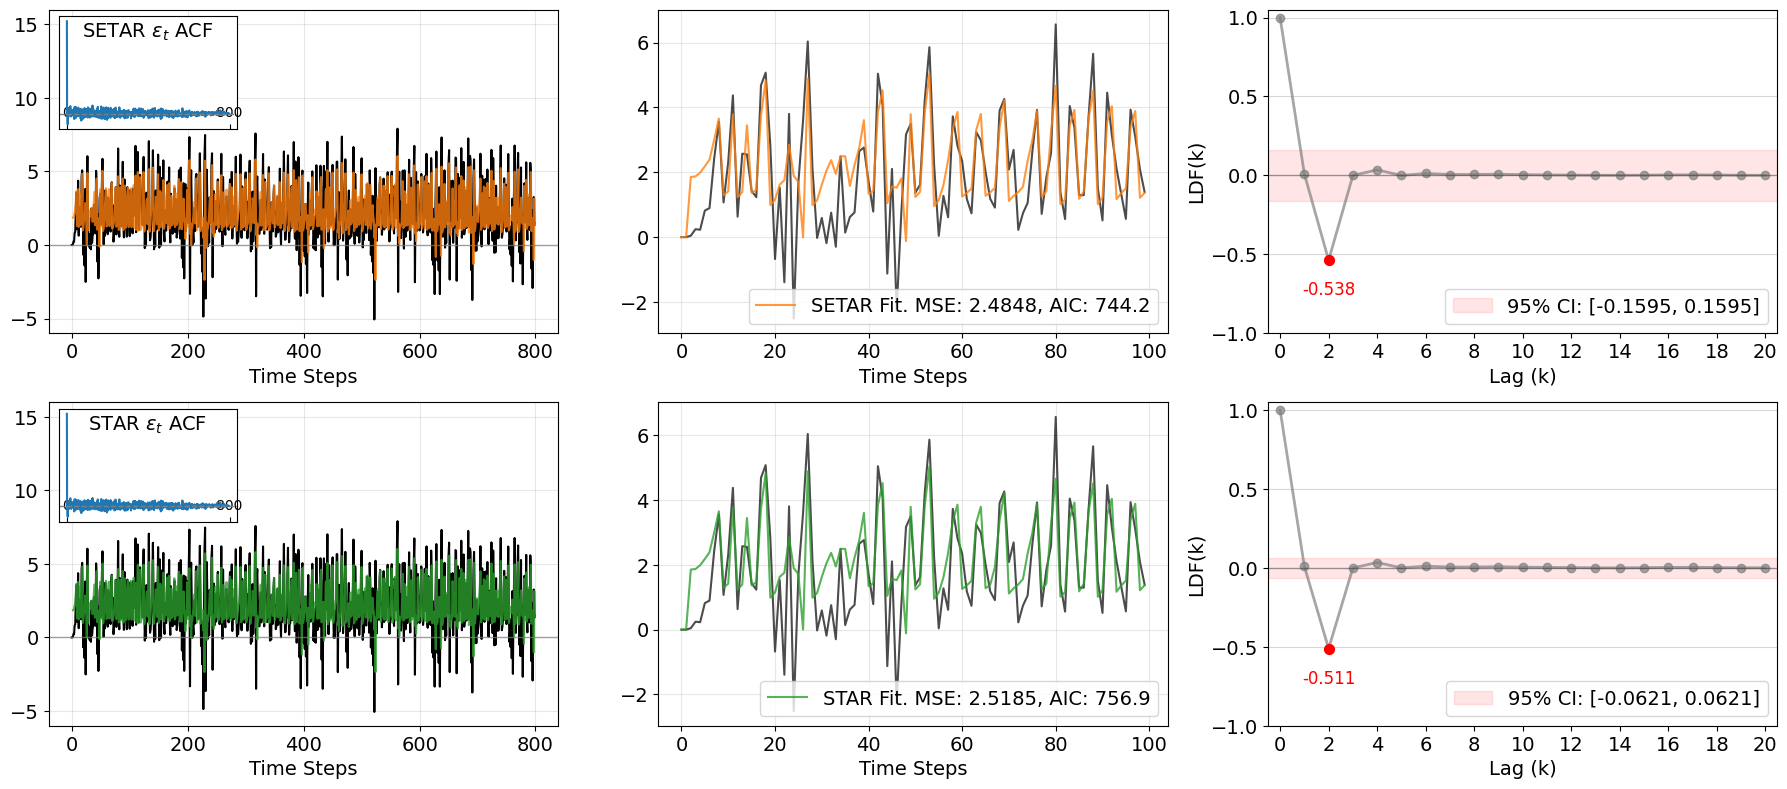

In [4]:
# STEP 2: Create plots (RUN AS MANY TIMES AS NEEDED)
n_models = len(first_models)
fig, axes = plt.subplots(n_models, 3, figsize=(18, 4*n_models))

# Handle case where there's only one model
if n_models == 1:
    axes = axes.reshape(1, -1)

# Plot each model in its row
for i, (name, fitted, resid, aic, color) in enumerate(first_models):
    plot_and_test(axes[i, 0], axes[i, 1], name, fitted, resid, aic, color)
    ldf_val, ldf_ci95 = first_ldf_results[name]
    plot_ldf(axes[i, 2], name, resid, ldf_val, ldf_ci95)

plt.tight_layout()
plt.savefig('plots/part5_all_models_with_ldf_star_setar.png', dpi=150, bbox_inches='tight')
plt.show()

In [5]:
# STEP 1: Fit all models and compute LDF (RUN ONCE)
models = []
ldf_results = {}

print("Fitting MMAR...")
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression
mmar_model = MarkovAutoregression(data5, k_regimes=2, order=2, switching_variance=False)
mmar_fit = mmar_model.fit()
mmar_fitted = mmar_fit.fittedvalues
mmar_residuals = data5[len(data5) - len(mmar_fitted):] - mmar_fitted
mmar_aic = mmar_fit.aic
mmar_fitted_padded = np.full(len(data5), np.nan)
mmar_fitted_padded[len(data5) - len(mmar_fitted):] = mmar_fitted
mmar_residuals_padded = np.full(len(data5), np.nan)
mmar_residuals_padded[len(data5) - len(mmar_fitted):] = mmar_residuals
models.append(('MMAR', mmar_fitted_padded, mmar_residuals_padded, mmar_aic, 'C3'))

print("Fitting IGAR...")
from IGAR import IGAR
igar_model = IGAR(order=2, n_regimes=2)
igar_model.fit(data5)
models.append(('IGAR', igar_model.fittedvalues, igar_model.resid, igar_model.aic, 'C4'))

# Compute LDF for all models
print("\nComputing LDF for all models...")
for name, fitted, resid, aic, color in models:
    print(f"Computing LDF for {name}...")
    res_valid = resid[~np.isnan(resid)]
    val, ci95 = ldf_r_like_fixed(res_valid, lags=list(range(1, 21)), frac=0.75, n_boot=10)
    ldf_results[name] = (val, ci95)

print("\nAll computations complete!")

Fitting MMAR...
Fitting IGAR...
Converged after 44 iterations

Computing LDF for all models...
Computing LDF for MMAR...
Calculating bootstrap no. 1 of 10
Calculating bootstrap no. 2 of 10
Calculating bootstrap no. 3 of 10
Calculating bootstrap no. 4 of 10
Calculating bootstrap no. 5 of 10
Calculating bootstrap no. 6 of 10
Calculating bootstrap no. 7 of 10
Calculating bootstrap no. 8 of 10
Calculating bootstrap no. 9 of 10
Calculating bootstrap no. 10 of 10
Computing LDF for IGAR...
Calculating bootstrap no. 1 of 10
Calculating bootstrap no. 2 of 10
Calculating bootstrap no. 3 of 10
Calculating bootstrap no. 4 of 10
Calculating bootstrap no. 5 of 10
Calculating bootstrap no. 6 of 10
Calculating bootstrap no. 7 of 10
Calculating bootstrap no. 8 of 10
Calculating bootstrap no. 9 of 10
Calculating bootstrap no. 10 of 10

All computations complete!


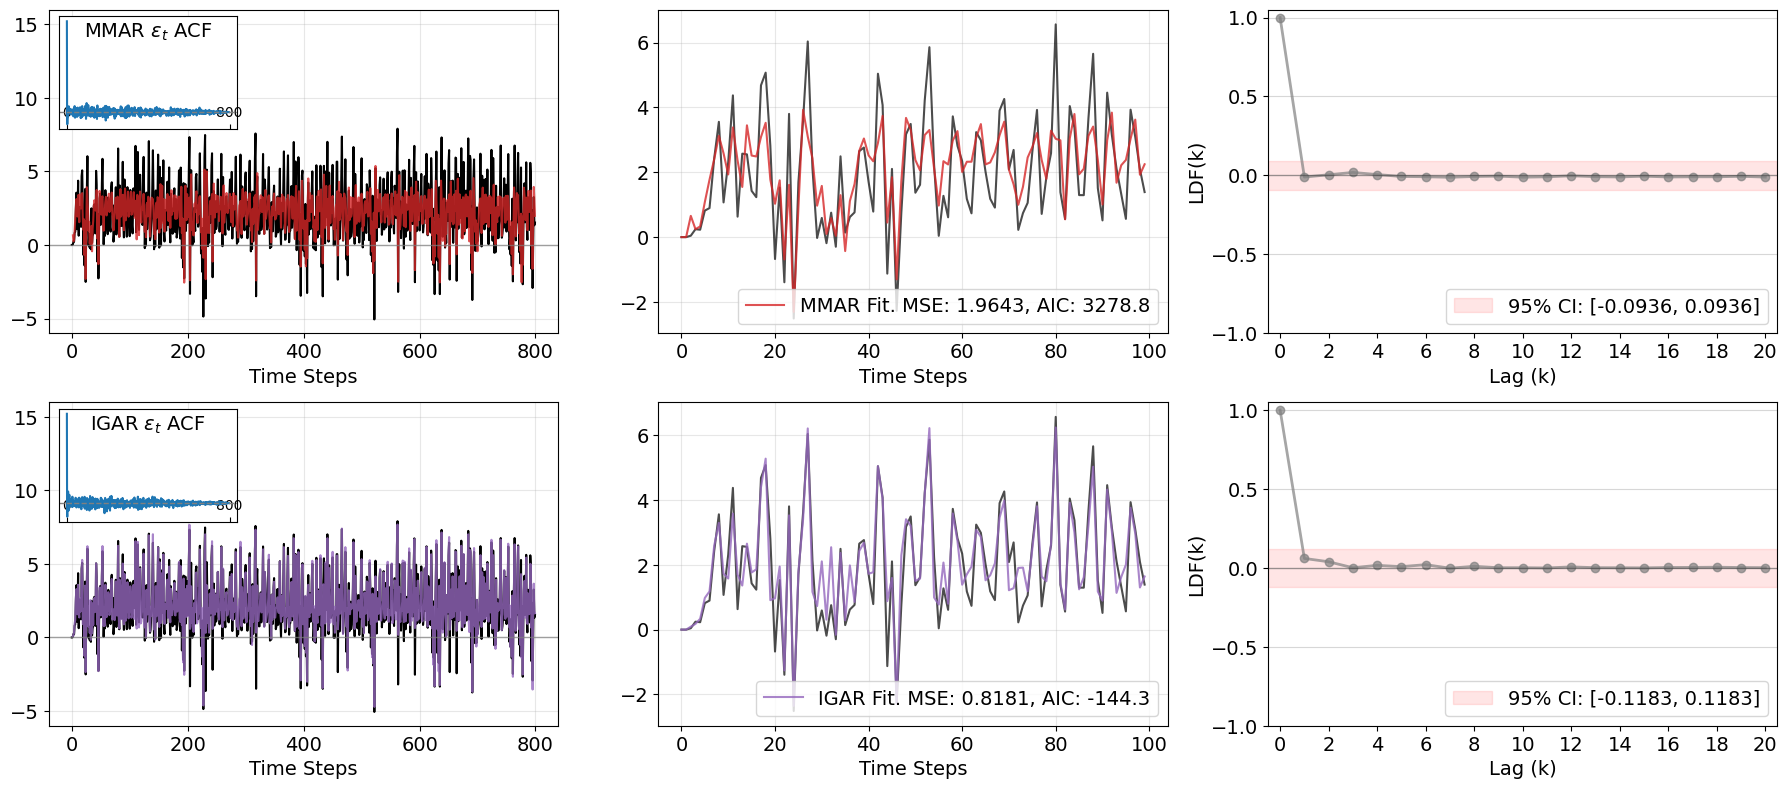

In [6]:
# STEP 2: Create plots (RUN AS MANY TIMES AS NEEDED)
n_models = len(models)
fig, axes = plt.subplots(n_models, 3, figsize=(18, 4*n_models))

# Handle case where there's only one model
if n_models == 1:
    axes = axes.reshape(1, -1)

# Plot each model in its row
for i, (name, fitted, resid, aic, color) in enumerate(models):
    plot_and_test(axes[i, 0], axes[i, 1], name, fitted, resid, aic, color)
    ldf_val, ldf_ci95 = ldf_results[name]
    plot_ldf(axes[i, 2], name, resid, ldf_val, ldf_ci95)

plt.tight_layout()
plt.savefig('plots/part5_all_models_with_ldf_mmar_igar.png', dpi=150, bbox_inches='tight')
plt.show()